# Integrantes - Caso 4

* Danny Diaz
* Daniel Ortega
* Ruben Tocain

# Instrucciones

1. Ingresar a https://scikit-learn.org/stable/datasets/toy_dataset.html y seleccionar un dataset de clasificación o regresión como caso de estudio.
2. Seleccionar 1 modelo de aprendizaje supervisado para abordar el caso de estudio.
3. Evaluar el modelo de clasificación o regresión mediante hold-out y seleccionar el mejor conjunto de hiperparámetros.
4. Evaluar 1 modelo de clasificación o regresión mediante validación cruzada con k-fold y seleccionar el mejor conjunto de hiperparámetros.

# Dependencias

In [7]:
import numpy as np
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report

# Preprocesamiento

In [2]:
dataset = fetch_20newsgroups(subset='all', categories=['alt.atheism', 'sci.space'], shuffle=True, random_state=42)

# Binarizar las etiquetas (necesario para ROC y AUC en caso multi-clase)
y = dataset.target
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Selección de hiperparámetros Hold-out + Grid Search + K-Fold

In [5]:
# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(dataset.data, y, test_size=0.2, random_state=42)

# Definir el vectorizador y el modelo en un pipeline
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=42))
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}

# Definir el número de pliegues para k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Usar GridSearchCV para encontrar los mejores hiperparámetros con k-fold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf)
grid_search.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = grid_search.best_estimator_.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Mejores hiperparámetros (Hold-out):", grid_search.best_params_)
print(f"Exactitud (Hold-out): {accuracy:.4f}")
print(f"Precisión (Hold-out): {precision:.4f}")
print(f"Recall (Hold-out): {recall:.4f}")

Mejores hiperparámetros (Hold-out): {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 200}
Exactitud (Hold-out): 0.9832
Precisión (Hold-out): 0.9837
Recall (Hold-out): 0.9832


In [8]:
print("Reporte de Clasificación (Hold-out):")
print(classification_report(y_test, y_pred))

Reporte de Clasificación (Hold-out):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       157
           1       0.97      1.00      0.99       201

    accuracy                           0.98       358
   macro avg       0.99      0.98      0.98       358
weighted avg       0.98      0.98      0.98       358



# AUC-ROC

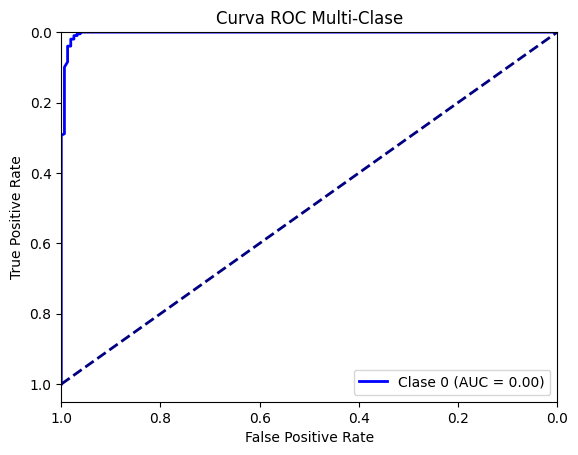

In [9]:
# Predecir probabilidades para calcular la curva ROC y AUC
y_prob = grid_search.best_estimator_.predict_proba(X_test)

# Binarizar solo las etiquetas del conjunto de prueba para ROC y AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Calcular curva ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors[:n_classes]):  # Limitar colores si hay más clases
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([1, 0], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([1.0, 0.0])
plt.ylim([1.05, 0.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multi-Clase')
plt.legend(loc="lower right")
plt.show()

# END